In [169]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [137]:
df = pd.read_csv("dirty_v3_path.csv").head(5000)

In [138]:
df.head()

,Age,Gender,Medical Condition,Glucose,Blood Pressure,BMI,Oxygen Saturation,LengthOfStay,Cholesterol,Triglycerides,HbA1c,Smoking,Alcohol,Physical Activity,Diet Score,Family History,Stress Level,Sleep Hours,random_notes,noise_col
0,46.0,Male,Diabetes,137.04,135.27,28.90,96.04,6,231.88,210.56,7.61,0,0,-0.20,3.54,0,5.07,6.05,lorem,-137.057211
1,22.0,Male,Healthy,71.58,113.27,26.29,97.54,2,165.57,129.41,4.91,0,0,8.12,5.90,0,5.87,7.72,ipsum,-11.230610
2,50.0,NaN,Asthma,95.24,NaN,22.53,90.31,2,214.94,165.35,5.60,0,0,5.01,4.65,1,3.09,4.82,ipsum,98.331195
3,57.0,NaN,Obesity,NaN,130.53,38.47,96.60,5,197.71,182.13,6.92,0,0,3.16,3.37,0,3.01,5.33,lorem,44.187175
4,66.0,Female,Hypertension,95.15,178.17,31.12,94.90,4,259.53,115.85,5.98,0,1,3.56,3.40,0,6.38,6.64,lorem,44.831426


In [139]:
df = df.drop(columns=['random_notes', 'noise_col'])

In [140]:
df.shape

(5000, 18)

In [141]:
df.isna().sum()

Age                  727
Gender               745
Medical Condition    743
Glucose              750
Blood Pressure       722
BMI                    0
Oxygen Saturation      0
LengthOfStay           0
Cholesterol            0
Triglycerides          0
HbA1c                  0
Smoking                0
Alcohol                0
Physical Activity      0
Diet Score             0
Family History         0
Stress Level           0
Sleep Hours            0
dtype: int64

Chci predikovat medicinal condition, takže null hodnoty dropnu

In [142]:
df = df[~df['Medical Condition'].isna()]

In [143]:
df.shape

(4257, 18)

In [144]:
df.isna().sum()

Age                  621
Gender               636
Medical Condition      0
Glucose              627
Blood Pressure       622
BMI                    0
Oxygen Saturation      0
LengthOfStay           0
Cholesterol            0
Triglycerides          0
HbA1c                  0
Smoking                0
Alcohol                0
Physical Activity      0
Diet Score             0
Family History         0
Stress Level           0
Sleep Hours            0
dtype: int64

In [145]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4257 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                3636 non-null   float64
 1   Gender             3621 non-null   object 
 2   Medical Condition  4257 non-null   object 
 3   Glucose            3630 non-null   float64
 4   Blood Pressure     3635 non-null   float64
 5   BMI                4257 non-null   float64
 6   Oxygen Saturation  4257 non-null   float64
 7   LengthOfStay       4257 non-null   int64  
 8   Cholesterol        4257 non-null   float64
 9   Triglycerides      4257 non-null   float64
 10  HbA1c              4257 non-null   float64
 11  Smoking            4257 non-null   int64  
 12  Alcohol            4257 non-null   int64  
 13  Physical Activity  4257 non-null   float64
 14  Diet Score         4257 non-null   float64
 15  Family History     4257 non-null   int64  
 16  Stress Level       4257 non-n

In [146]:
df['Age'] = df['Age'].fillna(df['Age'].mean())
df['Glucose'] = df['Glucose'].fillna(df['Glucose'].mean())
df['Blood Pressure'] = df['Blood Pressure'].fillna(df['Blood Pressure'].mean())
df['Gender'] = df['Gender'].fillna('Unknown')

<Figure size 1200x600 with 0 Axes>

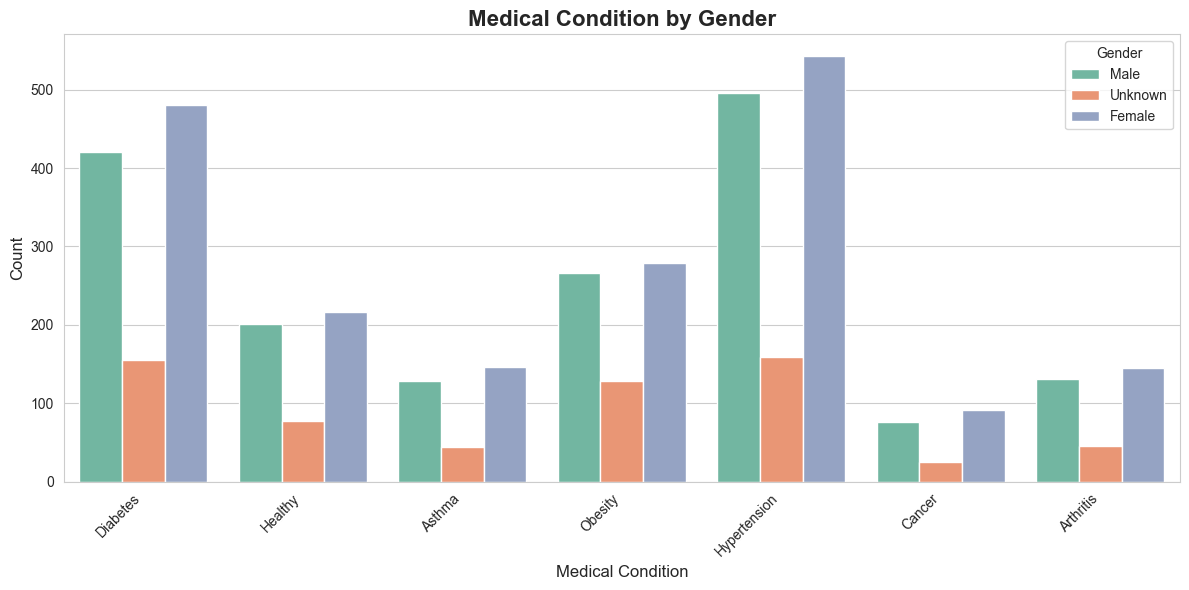

In [147]:
# Nastavení stylu
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))

# Vytvoření crosstab pro počty
condition_gender = pd.crosstab(df['Medical Condition'], df['Gender'])

# Alternativně s seaborn pro hezčí vzhled:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Medical Condition', hue='Gender', palette='Set2')
plt.title('Medical Condition by Gender', fontsize=16, fontweight='bold')
plt.xlabel('Medical Condition', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Gender')
plt.tight_layout()
plt.show()

In [148]:
df['Gender'].value_counts()

Gender
Female     1902
Male       1719
Unknown     636
Name: count, dtype: int64

Z grafu se nedá vyhodnotit, že by jedno pohlaví bylo více nemocné než druhé. Vyšší hodnoty u žen jsou způsobeny tím, že ženy jsou ve vzorku více zastoupeny.

Float sloupce: ['Age', 'Glucose', 'Blood Pressure', 'BMI', 'Oxygen Saturation', 'Cholesterol', 'Triglycerides', 'HbA1c', 'Physical Activity', 'Diet Score', 'Stress Level', 'Sleep Hours']


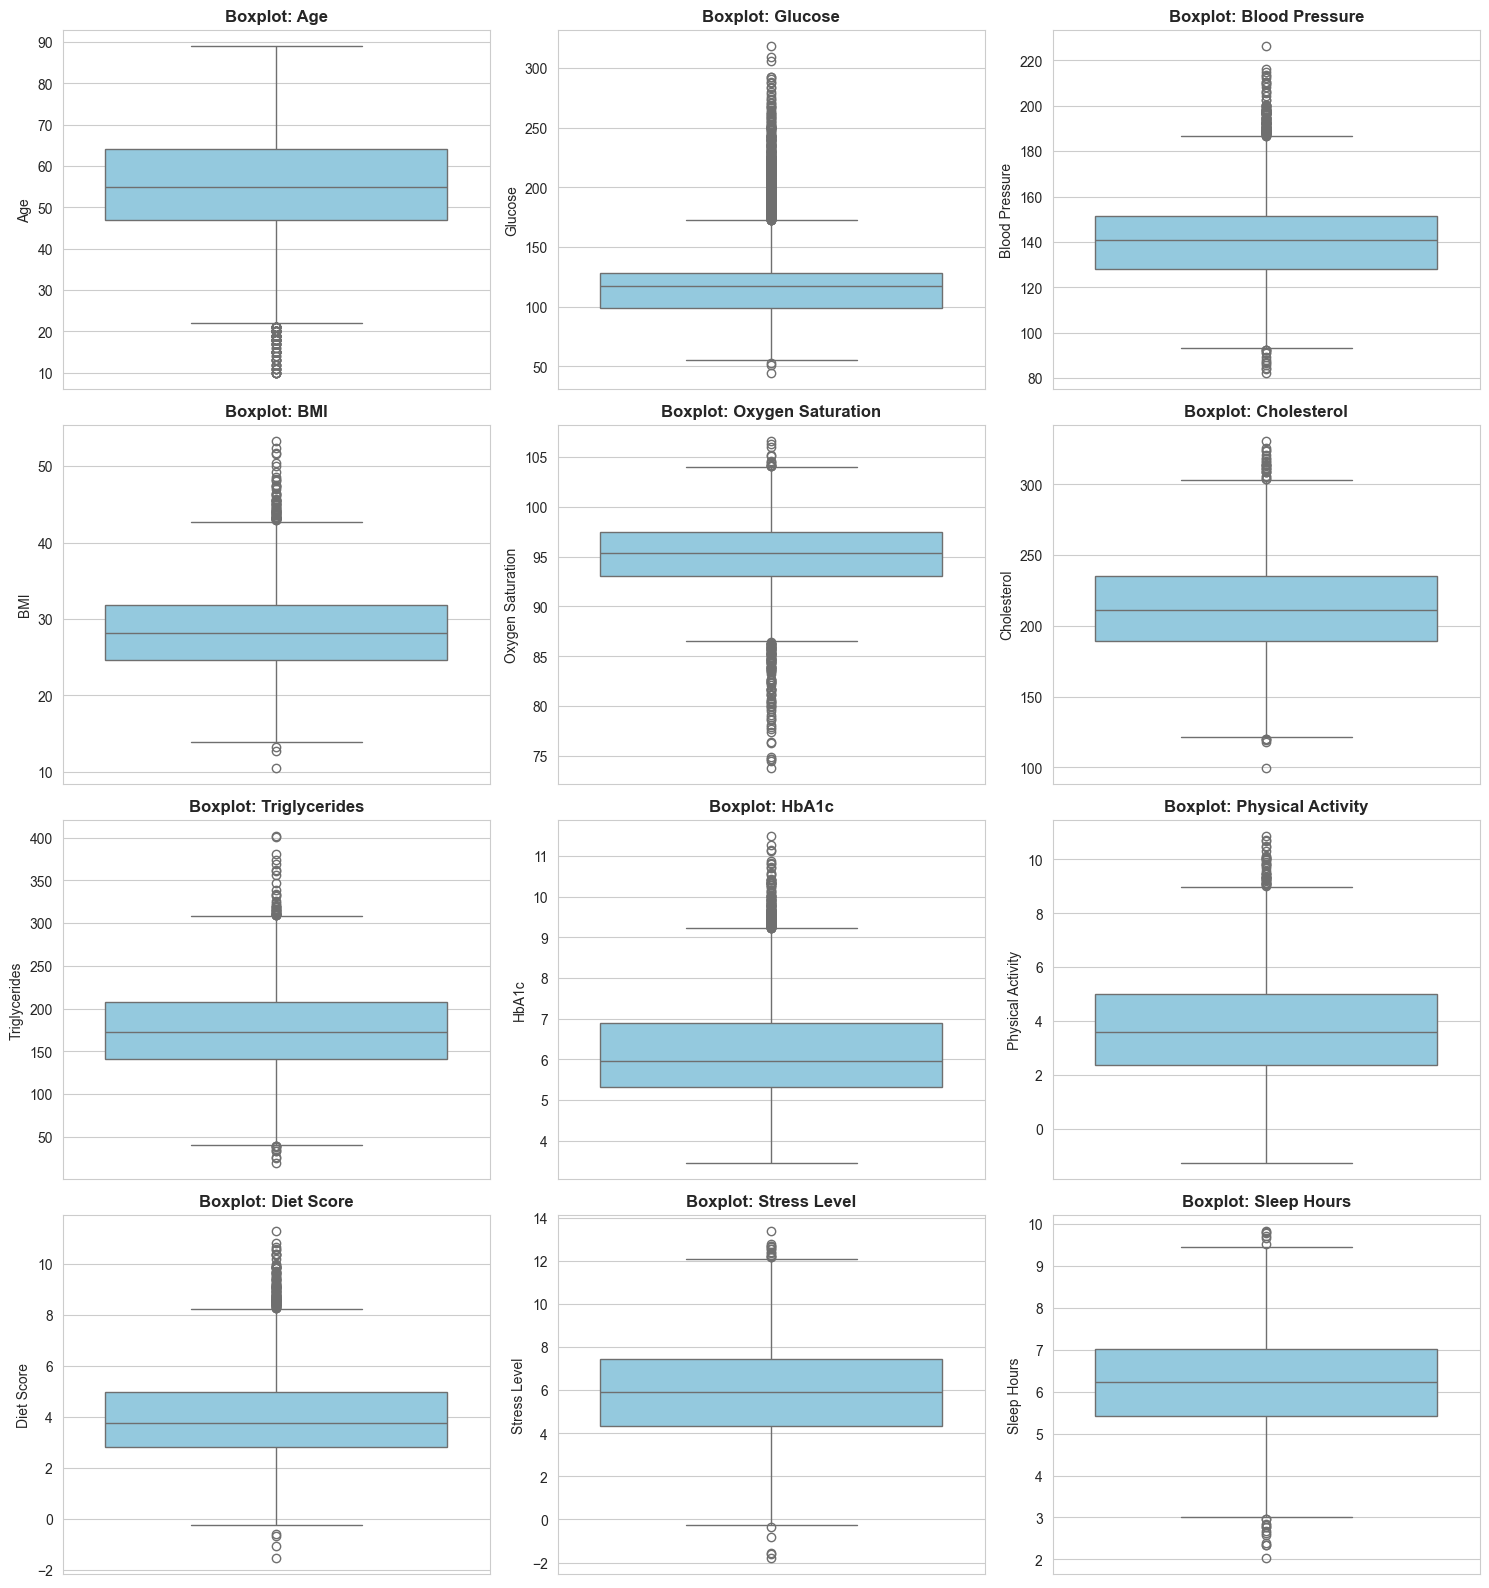

In [149]:
# Vyber všechny float sloupce
float_columns = df.select_dtypes(include=['float64']).columns.tolist()

print(f"Float sloupce: {float_columns}")

# Vytvoření boxplotů pro všechny float sloupce
n_cols = 3  # Počet sloupců v gridu
n_rows = (len(float_columns) + n_cols - 1) // n_cols  # Počet řádků

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()  # Zploštění pro jednodušší iteraci

for i, col in enumerate(float_columns):
    sns.boxplot(data=df, y=col, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Boxplot: {col}', fontsize=12, fontweight='bold')
    axes[i].set_ylabel(col, fontsize=10)

# Skrytí prázdných subplotů
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

Průměrný jedinec datasetu naspí něco málo nad 6 hodin, není příliš fyzicky aktivní, jeho strava je podprůměrná, má nad 50 let a žije poměrně stresuplným životem.

V důsledku toho je zvýšený cholesterol a krevní tlak.

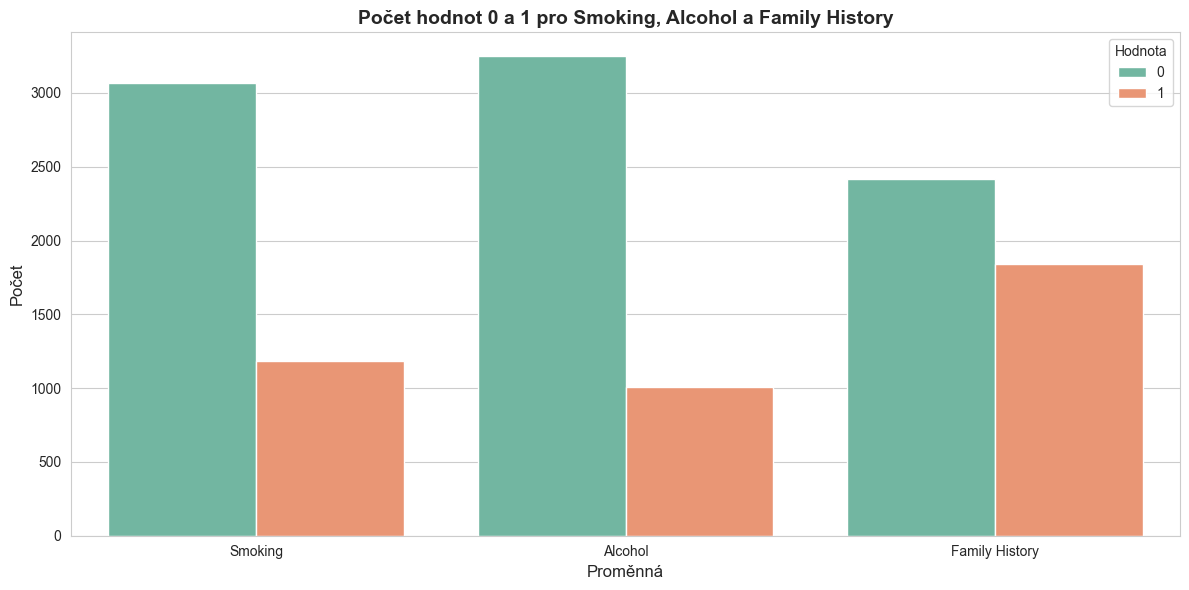

In [150]:
# Všechny tři proměnné vedle sebe
columns_to_plot = ['Smoking', 'Alcohol', 'Family History']

# Vytvoř data pro grouped barplot
data_for_plot = []
for col in columns_to_plot:
    counts = df[col].value_counts().sort_index()
    for val, count in counts.items():
        data_for_plot.append({'Variable': col, 'Value': str(int(val)), 'Count': count})

plot_df = pd.DataFrame(data_for_plot)

plt.figure(figsize=(12, 6))
sns.barplot(data=plot_df, x='Variable', y='Count', hue='Value', palette='Set2')
plt.title('Počet hodnot 0 a 1 pro Smoking, Alcohol a Family History', fontsize=14, fontweight='bold')
plt.xlabel('Proměnná', fontsize=12)
plt.ylabel('Počet', fontsize=12)
plt.legend(title='Hodnota')
plt.tight_layout()
plt.show()

Většina jedinců nekouří a ani nepije, ale je odhaleno, že spousta jedinců již má nemoc v rodině.

Taktéž více než polovina jedinců, má nemoc již v rodině. Ale vzhledem k nejčastějším nemocím bych si tipnul, že to hodně bude způsobeno tím, že převzali od rodičů špatnou životosprávu.

C:\Users\ajrac\AppData\Local\Temp\ipykernel_39692\432123048.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette='viridis')


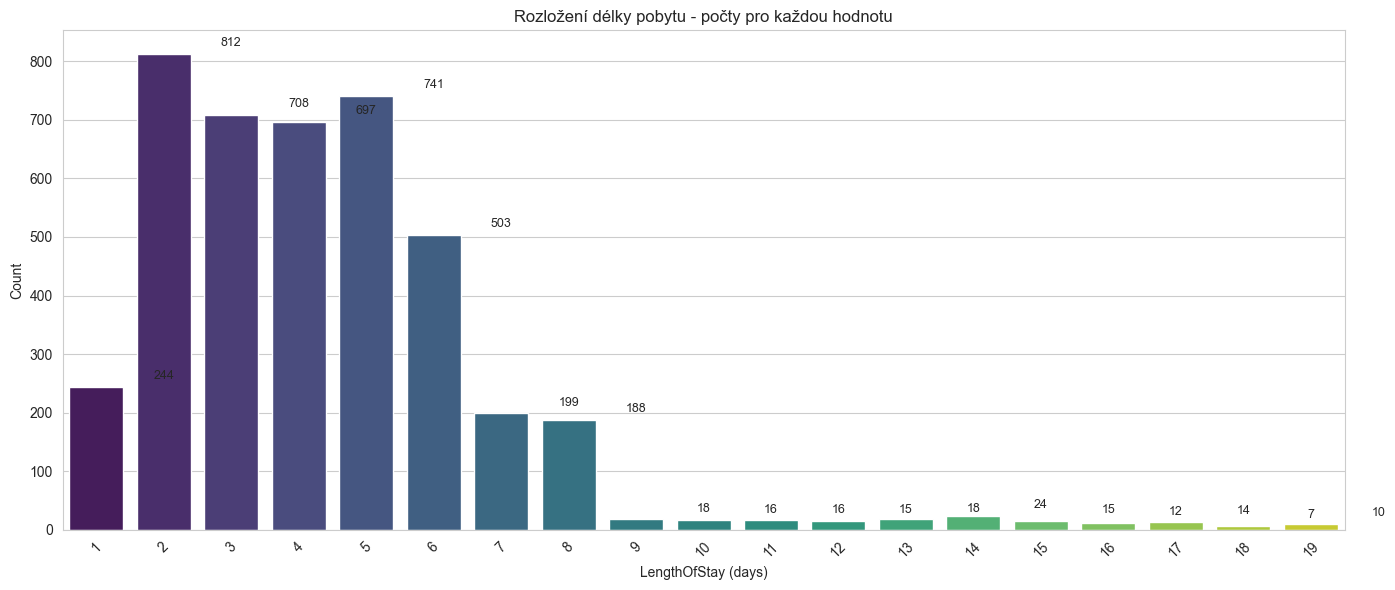

In [151]:
col = 'LengthOfStay'
s = pd.to_numeric(df[col], errors='coerce').astype(int)  # předpoklad: žádné NaN, sloupec existuje
counts = s.value_counts().sort_index()

plt.figure(figsize=(14,6))
sns.barplot(x=counts.index, y=counts.values, palette='viridis')
plt.xlabel('LengthOfStay (days)')
plt.ylabel('Count')
plt.title('Rozložení délky pobytu - počty pro každou hodnotu')
plt.xticks(rotation=45)
for x, y in zip(counts.index, counts.values):
    plt.text(x, y + max(counts.values) * 0.01, int(y), ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

Většina jedinců byla v nemocnici jen mezi 1 až 8 dny.

In [152]:
float_cols = df.select_dtypes(include=['float64', 'float32']).columns.tolist()
for c in float_cols:
    df = df[df[c] >= 0]

Mínusové hodnoty nedávají smysl a není jich hodně, tak je dropnu.

In [153]:
df.shape

(4197, 18)

C:\Users\ajrac\AppData\Local\Temp\ipykernel_39692\2007734404.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=condition_counts.index, x=condition_counts.values, palette='Set2', orient='h')


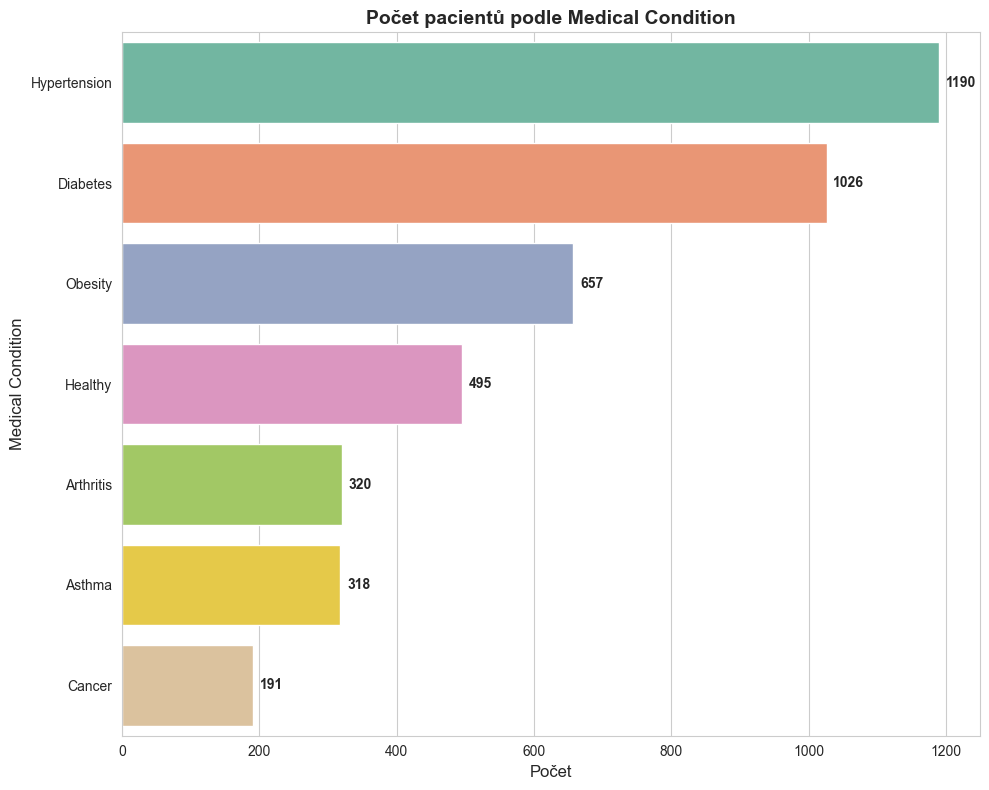

In [154]:
plt.figure(figsize=(10, 8))
condition_counts = df['Medical Condition'].value_counts()

sns.barplot(y=condition_counts.index, x=condition_counts.values, palette='Set2', orient='h')
plt.title('Počet pacientů podle Medical Condition', fontsize=14, fontweight='bold')
plt.xlabel('Počet', fontsize=12)
plt.ylabel('Medical Condition', fontsize=12)

# Přidej hodnoty na konec sloupců
for i, v in enumerate(condition_counts.values):
    plt.text(v + 10, i, str(v), va='center', fontweight='bold')

plt.tight_layout()
plt.show()

Nejvíce rozšířenou chorobou v datasetu je Hypertenze a cukrovka, což se vzhledem k hodnotám krevního tlaku a cholesterolu dá čekat. Co mě nicméně překvapuje je to, že obezita se objevuje jen zhruba u pětiny datasetu, vzlášť když cukrovka je u čtvrtiny. Předpokládal jsem, že počet cukrovky a obezity bude velmi podobný, nicméně tomu tak není.

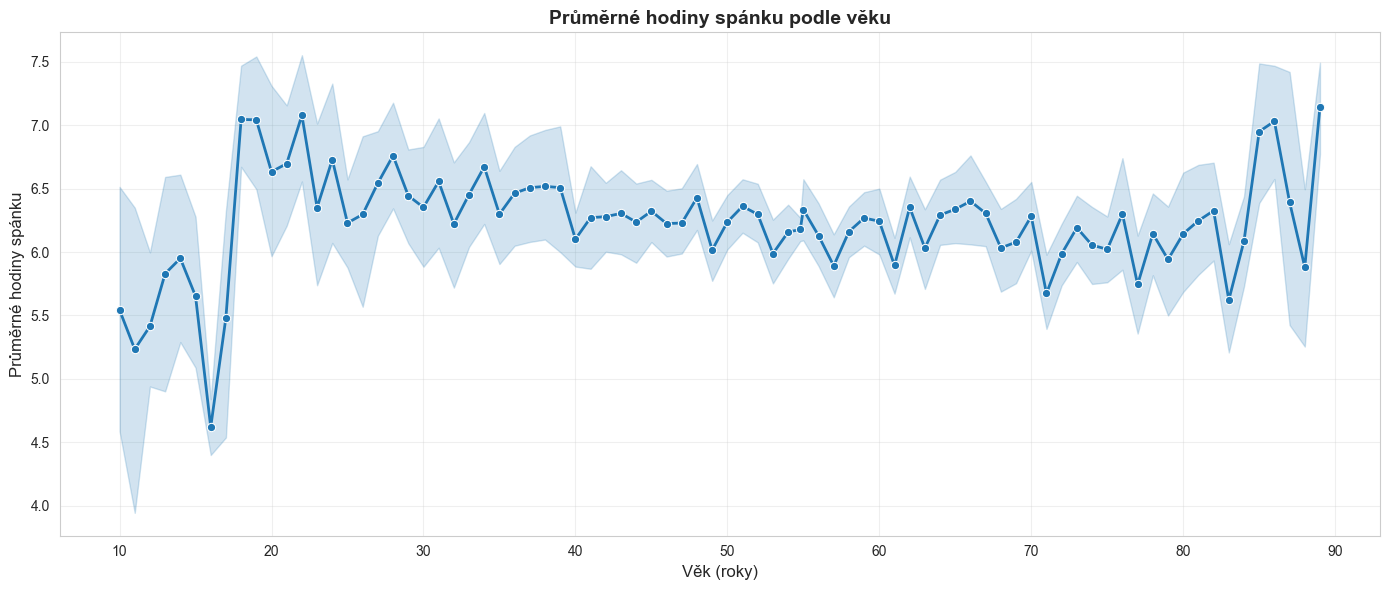

In [155]:
age_sleep = df.groupby('Age')['Sleep Hours'].mean().reset_index()

plt.figure(figsize=(14, 6))
sns.lineplot(data=df, x='Age', y='Sleep Hours', marker='o', linewidth=2, markersize=6)
plt.title('Průměrné hodiny spánku podle věku', fontsize=14, fontweight='bold')
plt.xlabel('Věk (roky)', fontsize=12)
plt.ylabel('Průměrné hodiny spánku', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Větší korelace mezi věkem a počtu odpsaných hodin není, nicméně skupina od 10 do 18 let má velmi málo odpsaných hodin, což může přispívat k nemoci.

C:\Users\ajrac\AppData\Local\Temp\ipykernel_39692\2844354680.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


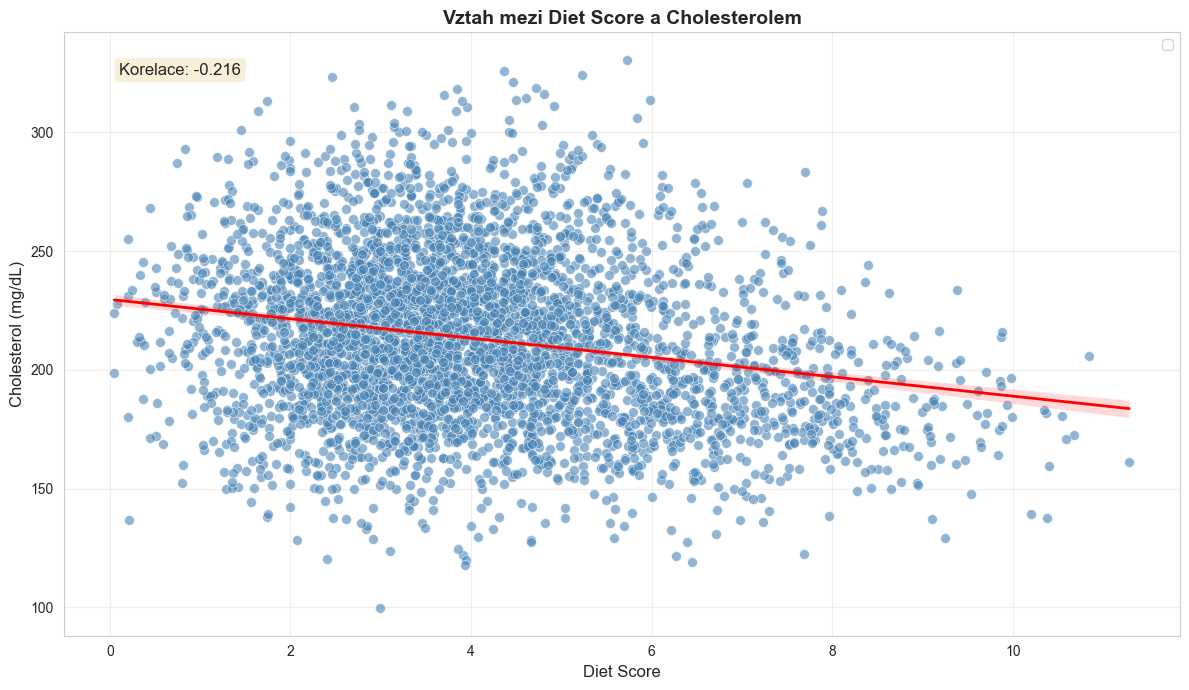

In [156]:
# Scatter plot - Diet Score vs Cholesterol
plt.figure(figsize=(12, 7))
sns.scatterplot(data=df, x='Diet Score', y='Cholesterol', alpha=0.6, s=50, color='steelblue')

# Přidej regresní čáru
sns.regplot(data=df, x='Diet Score', y='Cholesterol', scatter=False, color='red', 
            line_kws={'linewidth': 2, 'label': 'Regresní čára'})

plt.title('Vztah mezi Diet Score a Cholesterolem', fontsize=14, fontweight='bold')
plt.xlabel('Diet Score', fontsize=12)
plt.ylabel('Cholesterol (mg/dL)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()

# Vypočítej a zobraz korelaci
correlation = df['Diet Score'].corr(df['Cholesterol'])
plt.text(0.05, 0.95, f'Korelace: {correlation:.3f}', 
         transform=plt.gca().transAxes, fontsize=12, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

C:\Users\ajrac\AppData\Local\Temp\ipykernel_39692\455044292.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


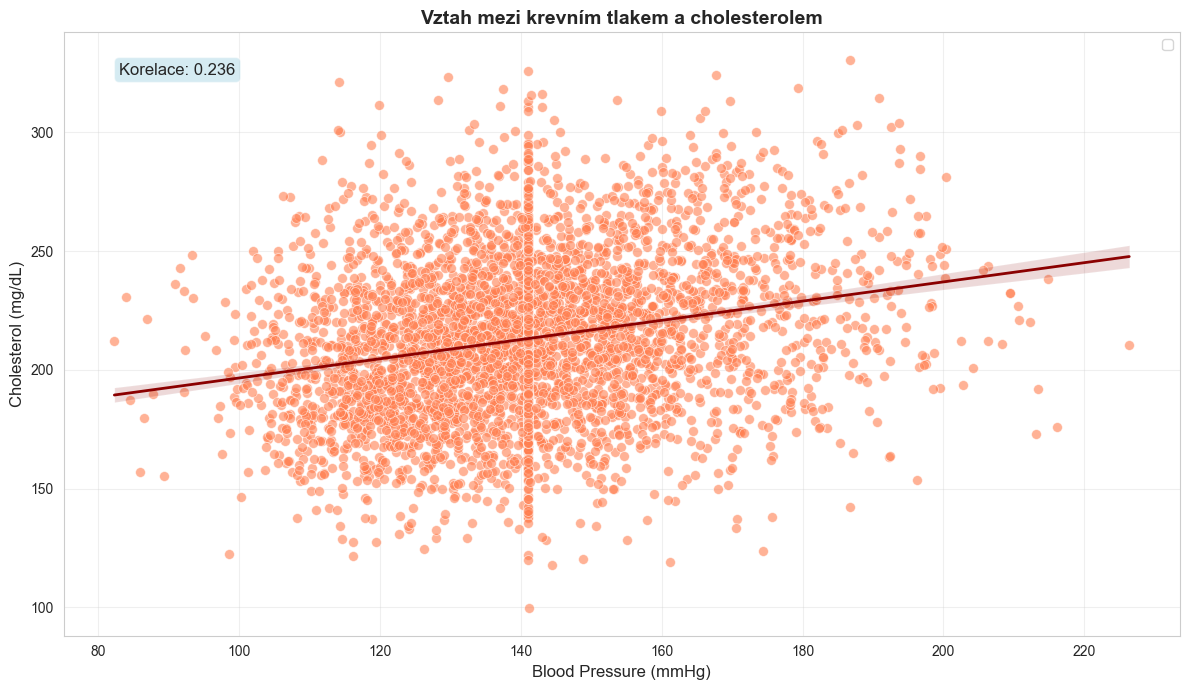

In [157]:
# Scatter plot - Blood Pressure vs Cholesterol
plt.figure(figsize=(12, 7))
sns.scatterplot(data=df, x='Blood Pressure', y='Cholesterol', alpha=0.6, s=50, color='coral')

# Přidej regresní čáru
sns.regplot(data=df, x='Blood Pressure', y='Cholesterol', scatter=False, color='darkred', 
            line_kws={'linewidth': 2, 'label': 'Regresní čára'})

plt.title('Vztah mezi krevním tlakem a cholesterolem', fontsize=14, fontweight='bold')
plt.xlabel('Blood Pressure (mmHg)', fontsize=12)
plt.ylabel('Cholesterol (mg/dL)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()

# Vypočítej a zobraz korelaci
correlation = df['Blood Pressure'].corr(df['Cholesterol'])
plt.text(0.05, 0.95, f'Korelace: {correlation:.3f}', 
         transform=plt.gca().transAxes, fontsize=12, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.tight_layout()
plt.show()

Zde jde vidět, že čím má člověk menší diet score, tím výšší má cholesterol.

A s tím souvisí i krevní tlak, čím vyšší je cholesterol, tím vyšší je krevní tlak.

Gender encoduji pomocí dummy encodingu, protože gender se nedá řadit a je ho v datasetu více než 2.

In [158]:
df = pd.get_dummies(df, columns=['Gender'], drop_first=False)

Převedu bool na int pro clustering.

In [159]:
for c in df.select_dtypes(include=['bool']).columns:
    df[c] = df[c].astype(int)
df.head()


,Age,Medical Condition,Glucose,Blood Pressure,BMI,Oxygen Saturation,LengthOfStay,Cholesterol,Triglycerides,HbA1c,Smoking,Alcohol,Physical Activity,Diet Score,Family History,Stress Level,Sleep Hours,Gender_Female,Gender_Male,Gender_Unknown
1,22.0,Healthy,71.580000,113.27000,26.29,97.54,2,165.57,129.41,4.91,0,0,8.12,5.90,0,5.87,7.72,0,1,0
2,50.0,Asthma,95.240000,140.99123,22.53,90.31,2,214.94,165.35,5.60,0,0,5.01,4.65,1,3.09,4.82,0,0,1
3,57.0,Obesity,123.713377,130.53000,38.47,96.60,5,197.71,182.13,6.92,0,0,3.16,3.37,0,3.01,5.33,0,0,1
4,66.0,Hypertension,95.150000,178.17000,31.12,94.90,4,259.53,115.85,5.98,0,1,3.56,3.40,0,6.38,6.64,1,0,0
5,50.0,Hypertension,107.000000,171.80000,25.33,95.21,5,233.10,203.67,5.48,1,0,5.01,4.65,0,7.25,6.35,0,1,0


Medical condition se nedá seřadit, takže se nehodí ordinal encoding, ale je to sloupec pro klasifikaci, takže se nehodí ani dummy encoding, tím páde to encoduji pomocí label encodingu.

In [160]:
clean_med = df['Medical Condition'].astype(str).str.strip()
le = LabelEncoder()
df['med_label'] = le.fit_transform(clean_med)
label_map = dict(zip(le.classes_, le.transform(le.classes_)))

In [161]:
label_map

{'Arthritis': np.int64(0),
 'Asthma': np.int64(1),
 'Cancer': np.int64(2),
 'Diabetes': np.int64(3),
 'Healthy': np.int64(4),
 'Hypertension': np.int64(5),
 'Obesity': np.int64(6)}

In [162]:
df['Oxygen Saturation'] = df['Oxygen Saturation'].clip(upper=100.0)

Clipnu saturaci kyslíku na 100, pravděpodobně se jedná o pár chyb měření.

Biologická data nejsu lineární, takže MinMaxScaler by s nimi měl problém, takže je třeba je rozdělit.

Pro lineární data je v pořádku použít MinMaxScaler, nicméně pro biologická data bude třeba použít PowerTransformer, který narovná data do Gaussovy křivky.

Speciálním případem je pak Oxygen Saturation, kde jsou data silně šikmé z leva, ale i zde je možné využít MinMaxSaler, jen nesmí být chybná data, např. 0 nebo 200%.

Zrcadlovým případem je pak LengthOfStay, nicméně data jsou šikmá z leva. Šikmost z leva je více nebezpečná než z prava. Problém pravého ocasu je ten, že směrem doprava často neexistuje strop, zatímco pro levý ocas existuje.

In [163]:
biological_features = [
    'Glucose', 'Blood Pressure', 'BMI', 'Cholesterol', 
    'Triglycerides', 'HbA1c', 'LengthOfStay'
]

linear_features = [
    'Age', 'Physical Activity', 'Diet Score', 'Stress Level', 
    'Sleep Hours', 'Oxygen Saturation'
]

In [164]:
bio_pipeline = Pipeline([
    ('log_normal', PowerTransformer(method='box-cox')),
    ('scale', MinMaxScaler())
])

linear_pipeline = Pipeline([
    ('minmax', MinMaxScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('bio_transform', bio_pipeline, biological_features),
        ('linear_transform', linear_pipeline, linear_features)
    ],
    verbose_feature_names_out=False # Zachová hezké názvy sloupců (v novějších scikit-learn)
).set_output(transform="pandas")

In [165]:
df_transformed = preprocessor.fit_transform(df)
df[df_transformed.columns] = df_transformed

In [166]:
df.head()

,Age,Medical Condition,Glucose,Blood Pressure,BMI,Oxygen Saturation,LengthOfStay,Cholesterol,Triglycerides,HbA1c,...,Alcohol,Physical Activity,Diet Score,Family History,Stress Level,Sleep Hours,Gender_Female,Gender_Male,Gender_Unknown,med_label
1,0.151899,Healthy,0.396486,0.327152,0.506573,0.906035,0.202245,0.353968,0.425599,0.464555,...,0,0.746999,0.520463,0,0.438202,0.729487,0,1,0,4
2,0.506329,Asthma,0.573438,0.545165,0.411527,0.629870,0.202245,0.572701,0.521085,0.590131,...,0,0.459834,0.409253,1,0.229963,0.357692,0,0,1,1
3,0.594937,Obesity,0.703562,0.468959,0.760008,0.870130,0.499109,0.499619,0.562488,0.752321,...,0,0.289012,0.295374,0,0.223970,0.423077,0,0,1,6
4,0.708861,Hypertension,0.572917,0.772783,0.615416,0.805195,0.423529,0.748921,0.386577,0.645272,...,1,0.325946,0.298043,0,0.476404,0.591026,1,0,0,5
5,0.506329,Hypertension,0.634736,0.737739,0.483275,0.817036,0.499109,0.646543,0.613242,0.570886,...,0,0.459834,0.409253,0,0.541573,0.553846,0,1,0,5


A jelikož Medical condition je pro klasifikaci, tak s ním nebudu pracovat během clusteringu.

In [167]:
X_clust = df.drop(columns=['Medical Condition', 'med_label'])

In [168]:
X_clust.head()

,Age,Glucose,Blood Pressure,BMI,Oxygen Saturation,LengthOfStay,Cholesterol,Triglycerides,HbA1c,Smoking,Alcohol,Physical Activity,Diet Score,Family History,Stress Level,Sleep Hours,Gender_Female,Gender_Male,Gender_Unknown
1,0.151899,0.396486,0.327152,0.506573,0.906035,0.202245,0.353968,0.425599,0.464555,0,0,0.746999,0.520463,0,0.438202,0.729487,0,1,0
2,0.506329,0.573438,0.545165,0.411527,0.629870,0.202245,0.572701,0.521085,0.590131,0,0,0.459834,0.409253,1,0.229963,0.357692,0,0,1
3,0.594937,0.703562,0.468959,0.760008,0.870130,0.499109,0.499619,0.562488,0.752321,0,0,0.289012,0.295374,0,0.223970,0.423077,0,0,1
4,0.708861,0.572917,0.772783,0.615416,0.805195,0.423529,0.748921,0.386577,0.645272,0,1,0.325946,0.298043,0,0.476404,0.591026,1,0,0
5,0.506329,0.634736,0.737739,0.483275,0.817036,0.499109,0.646543,0.613242,0.570886,1,0,0.459834,0.409253,0,0.541573,0.553846,0,1,0


Tímto jsou všechna data již připravena a můžou se použít pro clustering.

In [180]:
results_df = X_clust.copy()

1. experiment - KMeans

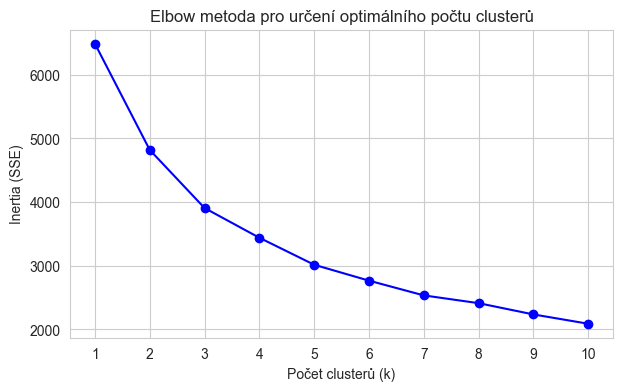

In [170]:
inertia = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_clust)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(7, 4))
plt.plot(K, inertia, "o-", color="blue")
plt.xlabel("Počet clusterů (k)")
plt.ylabel("Inertia (SSE)")
plt.title("Elbow metoda pro určení optimálního počtu clusterů")
plt.xticks(K)
plt.grid(True)
plt.show()

Z elbow metody není jasné, jaký počet clusterů by byl nejlepší, takže je třeba využít silhouette score

In [171]:
for k in [2, 3, 4, 5]:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_clust)
    score = silhouette_score(X_clust, labels)
    print(f"k = {k}: Silhouette Score = {score:.4f}")

k = 2: Silhouette Score = 0.2557
k = 3: Silhouette Score = 0.3258
k = 4: Silhouette Score = 0.2746
k = 5: Silhouette Score = 0.2703


Nejlepší počet clusterů je 3.

In [172]:
kmeans = KMeans(n_clusters=3, random_state=42)

In [ ]:
labels_exp1 = kmeans.fit_predict(X_clust)
results_df['Cluster_Exp1_KMeans'] = labels_exp1

In [175]:
numeric_columns = results_df.select_dtypes(include=[np.number]).columns
cluster_summary = results_df.groupby('Cluster_Exp1_KMeans')[numeric_columns].mean()

In [176]:
cluster_summary.T

Cluster_Exp1_KMeans,0,1,2
Age,0.589570,0.565922,0.552361
Glucose,0.684213,0.670799,0.659530
Blood Pressure,0.552370,0.535202,0.520789
BMI,0.552659,0.546500,0.547736
Oxygen Saturation,0.796691,0.809911,0.806904
LengthOfStay,0.437720,0.405456,0.384380
Cholesterol,0.570801,0.558882,0.551367
Triglycerides,0.549069,0.545212,0.532069
HbA1c,0.665860,0.647591,0.640057
Smoking,0.475666,0.285462,0.118524
